# Tensorflow

The standard example for machine learning these days is the MNIST data set, a collection of 70,000 handwriting samples of the numbers 0-9. Our challenge - to predict which number each handwritten image represents.

Each image is 28x28 grayscale pixels, so we can treat each image as just a 1D array, or tensor, of 784 numbers. As long as we're consistent in how we flatten each image into an array, it'll still work. Yes, it would be even better if we could preserve the 2D structure of the data while training - but we'll get there later.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
tf.enable_eager_execution()

MNIST provides 60,000 samples in a training data set, and 10,000 samples in a test data set.

In [2]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
print(len(x_train),len(x_test))

60000 10000


In [3]:
num_features = 28*28
num_classes = 10
X_train,X_test = np.array(x_train,np.float32),np.array(x_test,np.float32)
X_train,X_test = X_train.reshape([-1,num_features]),X_test.reshape([-1,num_features])
X_train,X_test = X_train/255,X_test/255

The training images are therefore a tensor of shape [60,000, 784] - 60,000 instances of 784 numbers that represent each image. The training labels are a one-dimensional tensor of 60,000 labels that range from 0 to 9.
Let's define a little function to let us visualize what the input data looks like, and pick some random training image to see what it is we're up against:

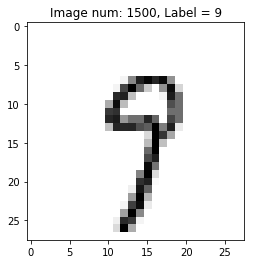

In [4]:
def show_image(num):
    label = y_train[num]
    image = X_train[num].reshape([28,28])
    plt.title("Image num: %d, Label = %d" % (num,label))
    plt.imshow(image,cmap=plt.get_cmap('gray_r'))
    plt.show()
show_image(1500)

As a reminder, we're flattening each image to a 1D array of 784 (28 x 28) numerical values. Each one of those values will be an input node into our deep neural network. Let's visualize how the data is being fed into it just to drive that point home:

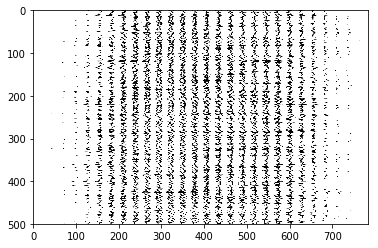

In [5]:
images = X_train[0].reshape([1,28*28])
for i in range(1,500):
    images = np.concatenate((images,X_train[i].reshape([1,28*28])))
plt.imshow(images,cmap=plt.get_cmap('gray_r'))
plt.show()

In [6]:
learning_rate = 0.001
batch_size = 250
display_size = 100
epoch = 4000
n_hidden = 512

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

We'll need an input layer with one node per input pixel per image, or 784 nodes. That will feed into a hidden layer of some arbitrary size - let's pick 512, given by n_hidden. That hidden layer will output 10 values, given by num_classes, corresonding to scores for each classification to be fed into softmax.

In [8]:
random_state = tf.random_normal_initializer()
weights = {
    'h':tf.Variable(random_state((num_features,n_hidden))),
    'out':tf.Variable(random_state((n_hidden,num_classes)))
}
biases = {
    'b':tf.Variable(tf.zeros(n_hidden)),
    'out':tf.Variable(tf.zeros(num_classes))
}


Now let's set up the neural network itself. We'll feed our input data into the first layer of our neural network. All this layer does is multiply these inputs by our weight "h" tensor which will be learned over time.
Then we'll feed that into our hidden layer, which applies the sigmoid activation function to the weighted inputs with our learned biases added in as well.
Finally our output layer, called out_layer, multiplies in the learned weights of the hidden layer and adds in the hidden layer's bias term.

In [9]:
def neural_net(inputData):
    # Hidden fully connected layer with 512 neurons.
    hidden_layer = tf.add(tf.matmul(inputData,weights['h']),biases['b'])
    # Apply sigmoid to hidden_layer output for non-linearity.
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer,weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

In [10]:
def cross_entropy(y_pred,y_true):
     # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true,depth=num_classes)
     # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9,1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

In [12]:
def run_optimization(x,y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred,y)
    # Variables to update, i.e. trainable variables.
    trainable_varibales = list(weights.values()) + list(biases.values())
    # Compute gradients.
    gradient = g.gradient(loss,trainable_varibales)
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradient,trainable_varibales))

In [13]:
# Accuracy metric.
def accuracy(y_pred,y_true):
    correct_prediction = tf.equal(tf.arg_max(y_pred,1),tf.cast(y_true,tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction,tf.float32),axis = -1)

In [14]:
# Run training for the given number of steps.
for step, (batch_x,batch_y) in enumerate(train_data.take(epoch),1):
    # Run the optimization to update W and b values
    run_optimization(batch_x,batch_y)
    if step % display_size == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred,batch_y)
        acc = accuracy(pred,batch_y)
        print("Training epoch: %i , loss: %f, accuracy: %f" %(step,loss,acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.math.argmax` instead
Training epoch: 100 , loss: 991.582703, accuracy: 0.636000
Training epoch: 200 , loss: 1026.298584, accuracy: 0.688000
Training epoch: 300 , loss: 893.920166, accuracy: 0.748000
Training epoch: 400 , loss: 714.060242, accuracy: 0.768000
Training epoch: 500 , loss: 628.425598, accuracy: 0.784000
Training epoch: 600 , loss: 731.636292, accuracy: 0.772000
Training epoch: 700 , loss: 677.542419, accuracy: 0.772000
Training epoch: 800 , loss: 841.728943, accuracy: 0.764000
Training epoch: 900 , loss: 687.893127, accuracy: 0.780000
Training epoch: 1000 , loss: 740.728699, accuracy: 0.804000
Training epoch: 1100 , loss: 702.725830, accuracy: 0.796000
Training epoch: 1200 , loss: 726.724182, accuracy: 0.800000
Training epoch: 1300 , loss: 625.154907, accuracy: 0.820000
Training epoch: 1400 , loss: 509.460846, accuracy: 0.844000
Training epoch: 15

In [15]:
# Test model on validation set.
pred = neural_net(X_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.922300


Let's take a look at some of the misclassified images and see just how good or bad our model is, compared to what your own brain can do. We'll go through the first 200 test images and look at the ones that are misclassified:

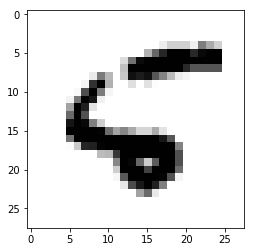

Original Labels: 5
Model prediction: 6


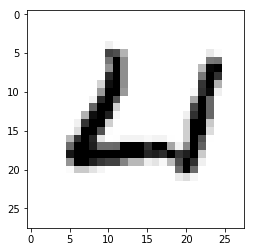

Original Labels: 4
Model prediction: 6


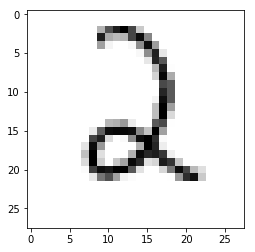

Original Labels: 2
Model prediction: 6


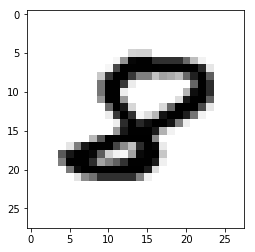

Original Labels: 8
Model prediction: 2


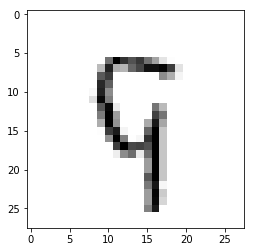

Original Labels: 9
Model prediction: 4


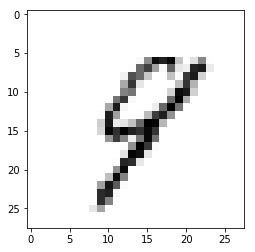

Original Labels: 9
Model prediction: 4


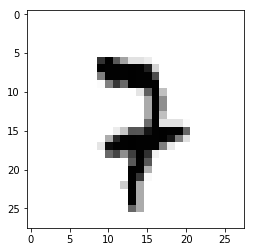

Original Labels: 7
Model prediction: 2


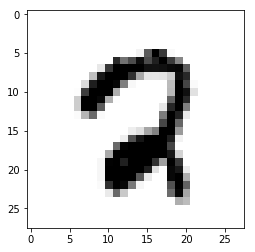

Original Labels: 2
Model prediction: 7


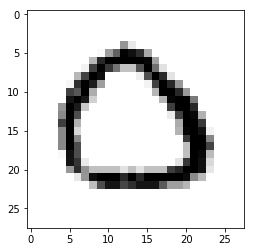

Original Labels: 0
Model prediction: 3


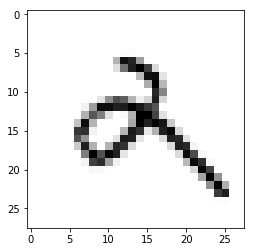

Original Labels: 2
Model prediction: 0


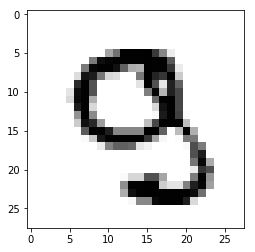

Original Labels: 9
Model prediction: 3


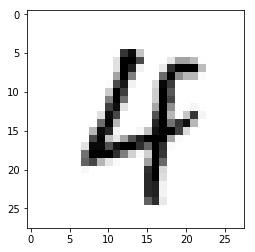

Original Labels: 4
Model prediction: 9


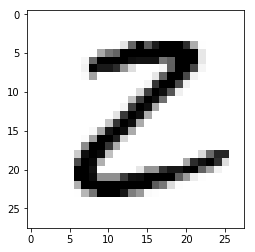

Original Labels: 2
Model prediction: 8


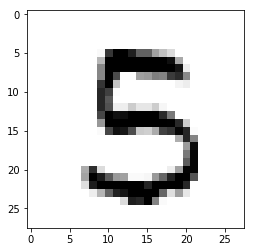

Original Labels: 5
Model prediction: 3


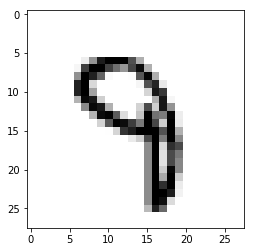

Original Labels: 9
Model prediction: 4


In [16]:
n_images = 200
test_images = X_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)